In this notebook we will see a fast method to solve the Kernel regression problem \
$\mathbf{K\alpha=y}$
where \
$\mathbf{K}$ is a $n\times n$ matrix of pairwise kernel evaluations between $n$ training samples\
$\mathbf{y}$ is the vector of $n$ training labels, and\
$\mathbf{\alpha}$ is the parameter vector to be learned.

So far we have solved this system of linear equations using `np.linalg.solve`
which requires $O(n^3)$ FLOPS and $O(n^2)$ memory

This notebook showcases a fast iterative solver which takes $O(n^2/m)$ FLOPs per epoch and $O(n)$ memory where $m$ is the number of threads on your GPU.\

You can `pip install` the solver from instructions [at this URL](https://github.com/EigenPro/EigenPro-pytorch/tree/pytorch)

# Load Data

The datasets file assumes you have defined an environment variable `$DATA_DIR` which is the directory where all the datasets are stored\
Currently the following datasets have been test, but feel free to add more and push your commits
- MNIST
- FashionMNIST
- KMNIST
- EMNIST
- CIFAR-10

In [1]:
import torch, datasets

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

n_class, (x_train, y_train), (x_test, y_test) = datasets.load('cifar10', DEVICE, split='digits')

Loaded CIFAR10 dataset to cuda
10 classes
50000 train samples
10000 test samples
--------------------


# Visualize samples

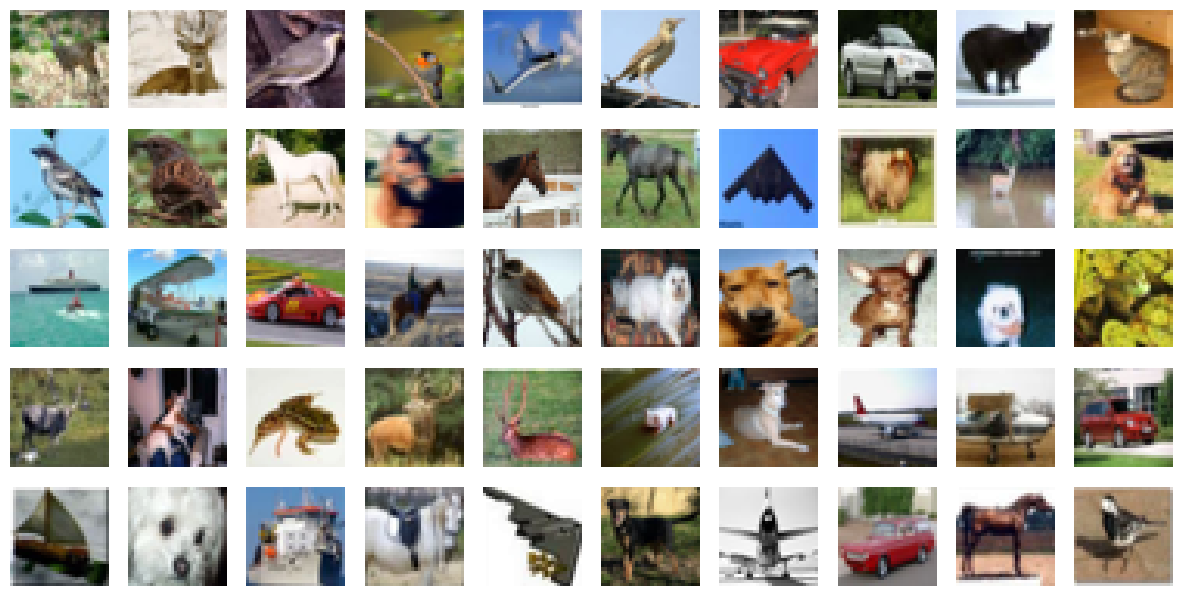

In [2]:
n_rows, n_cols = 5, 10
import numpy as np, matplotlib.pyplot as plt
samples = x_train[np.random.choice(len(x_train), n_rows * n_cols)]
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*1.5, n_rows*1.5))
for i, ax in enumerate(axes.ravel()):
    im=samples[i].reshape(32,32,3).cpu()
    ax.imshow((im-im.min())/(im.max()-im.min()))
    ax.axis('off')

# Preprocess data

In [3]:
x_train=x_train/x_train.norm(dim=-1,keepdim=True)
x_test=x_test/x_test.norm(dim=-1,keepdim=True)

# Choose a kernel

In [4]:
from eigenpro.kernels import laplacian, ntk_relu_unit_sphere as relu_ntk

kernel_fn = lambda x, y: laplacian(x, y, bandwidth=1.)
#kernel_fn = lambda x, z: relu_ntk(x, z, depth=3)

# Define a model and fit

In [5]:
import eigenpro

model = eigenpro.EigenProRegressor(kernel_fn, x_train, n_class, device=DEVICE)

results = model.fit(x_train, y_train, x_test, y_test, epochs=20, print_every=2, mem_gb=20)

SVD time: 10.14s, top_q: 131, top_eigval: 0.56, new top_eigval: 4.88e-04
n_subsamples=2000, bs_gpu=2000, eta=2000.00, bs=2000, top_eigval=5.62e-01, beta=1.00
--------------------
epoch:   0    time: 02.7s    train accuracy: 88.42%    val accuracy: 53.19%    train mse: 3.88e-02    val mse: 6.54e-02
epoch:   2    time: 03.2s    train accuracy: 99.72%    val accuracy: 57.46%    train mse: 1.45e-02    val mse: 6.10e-02
epoch:   4    time: 03.2s    train accuracy: 100.00%    val accuracy: 58.62%    train mse: 6.12e-03    val mse: 5.97e-02
epoch:   6    time: 03.2s    train accuracy: 100.00%    val accuracy: 59.13%    train mse: 2.82e-03    val mse: 5.92e-02
epoch:   8    time: 03.2s    train accuracy: 100.00%    val accuracy: 59.52%    train mse: 1.37e-03    val mse: 5.90e-02
epoch:  10    time: 03.2s    train accuracy: 100.00%    val accuracy: 59.71%    train mse: 7.03e-04    val mse: 5.89e-02
epoch:  12    time: 03.2s    train accuracy: 100.00%    val accuracy: 59.78%    train mse: 3.73e-

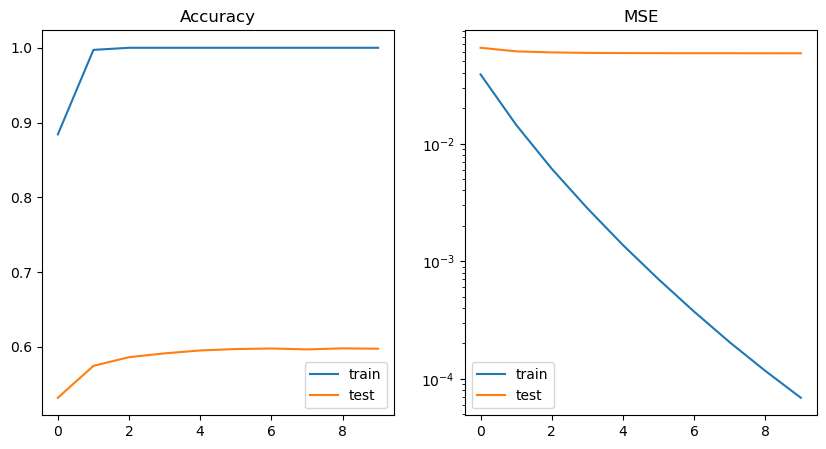

In [8]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(torch.tensor([results[i][0]['multiclass-acc'] for i in results.keys()]), label='train')
plt.plot(torch.tensor([results[i][1]['multiclass-acc'] for i in results.keys()]), label='test')
plt.legend()
plt.title('Accuracy')
plt.subplot(1,2,2)
plt.plot(torch.tensor([results[i][0]['mse'] for i in results.keys()]), label='train')
plt.plot(torch.tensor([results[i][1]['mse'] for i in results.keys()]), label='test')
plt.yscale('log')
plt.title('MSE')
_=plt.legend()